### Install libraries

In [8]:
!pip install -q transformers datasets

### Imports & device setup

In [12]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from transformers import BertTokenizerFast, BertForSequenceClassification, get_linear_schedule_with_warmup

from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_curve, auc
)

import matplotlib.pyplot as plt
import seaborn as sns

import random
import os

In [13]:
# For reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load the Kaggle IMDB dataset

In [15]:
from google.colab import files

uploaded = files.upload()  # Upload IMDB Dataset.csv

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [16]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Basic preprocessing

In [17]:
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})
df.head(), df['sentiment'].value_counts()

(                                              review  sentiment
 0  One of the other reviewers has mentioned that ...          1
 1  A wonderful little production. <br /><br />The...          1
 2  I thought this was a wonderful way to spend ti...          1
 3  Basically there's a family where a little boy ...          0
 4  Petter Mattei's "Love in the Time of Money" is...          1,
 sentiment
 1    25000
 0    25000
 Name: count, dtype: int64)

#### Split into train / validation / test:

In [18]:
# 80% train, 10% val, 10% test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['review'].values,
    df['sentiment'].values,
    test_size=0.2,
    random_state=seed_val,
    stratify=df['sentiment'].values
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=seed_val,
    stratify=temp_labels
)

len(train_texts), len(val_texts), len(test_texts)

(40000, 5000, 5000)

### Load BERT tokenizer

In [19]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Create a custom PyTorch Dataset

In [20]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

#### Create dataset objects:

In [21]:
max_len = 256

train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, max_len=max_len)
val_dataset   = IMDBDataset(val_texts,   val_labels,   tokenizer, max_len=max_len)
test_dataset  = IMDBDataset(test_texts,  test_labels,  tokenizer, max_len=max_len)

#### Create DataLoaders

In [22]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

### Load BERT for sequence classification

In [23]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Set up optimizer & scheduler

In [24]:
epochs = 3
learning_rate = 2e-5

optimizer = AdamW(model.parameters(), lr=learning_rate)

total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps
)

### Training & evaluation helper functions

In [25]:
def train_one_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [26]:
def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0.0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            probs = torch.softmax(logits, dim=-1)[:, 1]  # prob of class 1
            preds = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary'
    )

    metrics = {
        "loss": avg_loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "labels": np.array(all_labels),
        "preds": np.array(all_preds),
        "probs": np.array(all_probs),
    }

    return metrics

### Train the model (with history tracking)

In [27]:
train_history = {
    "train_loss": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": []
}

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    print("-" * 30)

    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Train loss: {train_loss:.4f}")

    val_metrics = eval_model(model, val_loader, device)
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    val_f1 = val_metrics["f1"]

    train_history["train_loss"].append(train_loss)
    train_history["val_loss"].append(val_loss)
    train_history["val_acc"].append(val_acc)
    train_history["val_f1"].append(val_f1)

    print(f"Val loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    print()

Epoch 1/3
------------------------------
Train loss: 0.2915
Val loss: 0.2249 | Val Acc: 0.9194 | Val F1: 0.9205

Epoch 2/3
------------------------------
Train loss: 0.1592
Val loss: 0.2420 | Val Acc: 0.9262 | Val F1: 0.9279

Epoch 3/3
------------------------------
Train loss: 0.0856
Val loss: 0.3021 | Val Acc: 0.9290 | Val F1: 0.9294



### Plot training & validation metrics
Loss vs epochs

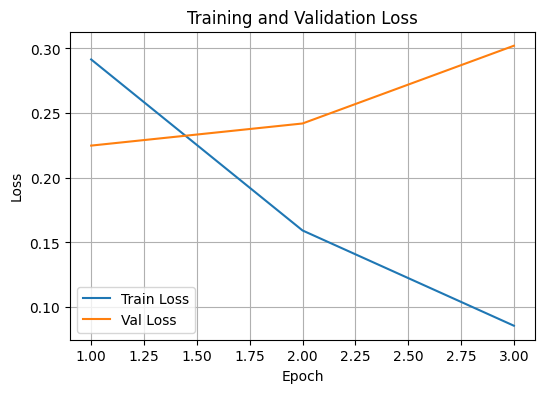

In [28]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_history["train_loss"], label='Train Loss')
plt.plot(epochs_range, train_history["val_loss"], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

##### Accuracy & F1 vs epochs

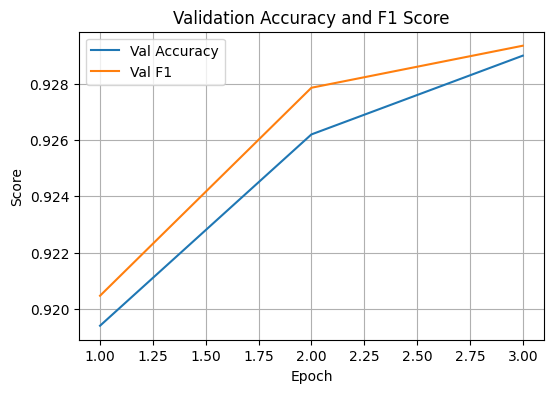

In [29]:
plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_history["val_acc"], label='Val Accuracy')
plt.plot(epochs_range, train_history["val_f1"], label='Val F1')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Accuracy and F1 Score")
plt.legend()
plt.grid(True)
plt.show()

### Final model performance testing on test set

In [30]:
test_metrics = eval_model(model, test_loader, device)

print("Test Loss:", test_metrics["loss"])
print("Test Accuracy:", test_metrics["accuracy"])
print("Test Precision:", test_metrics["precision"])
print("Test Recall:", test_metrics["recall"])
print("Test F1:", test_metrics["f1"])

Test Loss: 0.30300974698414423
Test Accuracy: 0.929
Test Precision: 0.9312424607961399
Test Recall: 0.9264
Test F1: 0.928814918788851


### Classification report

In [31]:
print("Classification Report:")
print(classification_report(test_metrics["labels"], test_metrics["preds"], target_names=["negative", "positive"]))

Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.93      0.93      2500
    positive       0.93      0.93      0.93      2500

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



### Confusion matrix heatmap

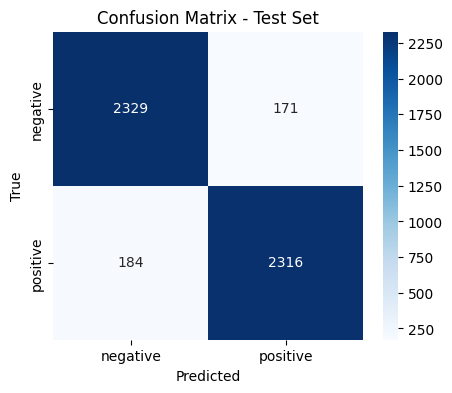

In [32]:
cm = confusion_matrix(test_metrics["labels"], test_metrics["preds"])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["negative", "positive"],
            yticklabels=["negative", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()

### ROC curve & AUC

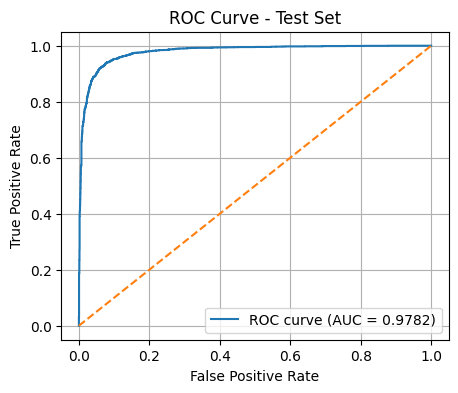

In [33]:
fpr, tpr, thresholds = roc_curve(test_metrics["labels"], test_metrics["probs"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.grid(True)
plt.show()

### Prediction on new sentences

In [34]:
def predict_sentiment(texts, model, tokenizer, max_len=256, device=device):
    model.eval()
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='pt'
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

    preds = preds.cpu().numpy()
    probs = probs.cpu().numpy()

    results = []
    for i, text in enumerate(texts):
        label = "positive" if preds[i] == 1 else "negative"
        confidence = probs[i][preds[i]]
        results.append((text, label, float(confidence)))
    return results

##### testing

In [35]:
sample_texts = [
    "This movie was absolutely fantastic, I loved every moment of it!",
    "The film was boring and a complete waste of time."
]

predictions = predict_sentiment(sample_texts, model, tokenizer)
for text, label, conf in predictions:
    print(f"Text: {text}\nPredicted: {label} (conf={conf:.4f})\n")

Text: This movie was absolutely fantastic, I loved every moment of it!
Predicted: positive (conf=0.9969)

Text: The film was boring and a complete waste of time.
Predicted: negative (conf=0.9992)



### Save the trained model (PyTorch)

##### Save in Hugging Face format


In [36]:
save_directory = "bert_imdb_model"

if not os.path.exists(save_directory):
    os.makedirs(save_directory)

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to: {save_directory}")

Model and tokenizer saved to: bert_imdb_model


### Save only PyTorch state dict (optional)

In [37]:
state_dict_path = "bert_imdb_state_dict.pt"
torch.save(model.state_dict(), state_dict_path)
print(f"PyTorch state dict saved to: {state_dict_path}")

PyTorch state dict saved to: bert_imdb_state_dict.pt


### Load the saved model later and test again

In [38]:
loaded_tokenizer = BertTokenizerFast.from_pretrained(save_directory)
loaded_model = BertForSequenceClassification.from_pretrained(save_directory)
loaded_model.to(device)

# Re-evaluate on test set to verify everything works
loaded_test_metrics = eval_model(loaded_model, test_loader, device)
print("Loaded model - Test Accuracy:", loaded_test_metrics["accuracy"])

Loaded model - Test Accuracy: 0.929
